In [2]:
import sys
sys.path.insert(0, "..")
# TODO work on imports
from mir.distances import graph
import pandas as pd
import time
from plotnine import *

In [3]:
vdjdb = pd.read_csv('assets/vdjdb.slim.txt', sep='\t')
print(vdjdb.head())
vdjdb[vdjdb['gene'] == 'TRB']['antigen.epitope'].value_counts()

  gene             cdr3        species antigen.epitope antigen.gene  \
0  TRB  CASSTSRLSNQPQYF  MacacaMulatta        STPESANL          Tat   
1  TRB  CASSQDRGPANEQFF    HomoSapiens       RLRAEAQVK       EBNA3A   
2  TRB  CASSMSRSSNQPQYF  MacacaMulatta        TTPESANL          Tat   
3  TRA    CASNTGTASKLTF    HomoSapiens       GILGFVFTL            M   
4  TRB    CASSLGSQNTLYF    MusMusculus       HGIRNASFI          M45   

  antigen.species                     complex.id       v.segm      j.segm  \
0             SIV                              0    TRBV14*01  TRBJ1-5*01   
1             EBV                          21729   TRBV4-1*01  TRBJ2-1*01   
2             SIV                              0    TRBV14*01  TRBJ1-5*01   
3      InfluenzaA                              0    TRAV24*01   TRAJ44*01   
4            MCMV  24797,24785,24840,24778,24833  TRBV12-1*01  TRBJ2-4*01   

   v.end  j.start        mhc.a mhc.b mhc.class  \
0      4        8    Mamu-A*01   B2M      MHCI   
1      5  

antigen.epitope
KLGGALQAK        12667
NLVPMVATV         4697
GILGFVFTL         3501
AVFDRKSDAK        1648
ELAGIGILTV        1422
                 ...  
VMPLSAPTL            1
FGDDTVIEV            1
KQWLVWLFL            1
QHIRCNIPKRISA        1
IPTNFTISV            1
Name: count, Length: 1168, dtype: int64

In [4]:
def get_seqs(epi, size = 1000, gene = 'TRB'):
    return vdjdb[vdjdb['gene'].eq(gene) & vdjdb['antigen.epitope'].isin(epi)] \
        .groupby('antigen.epitope') \
        .apply(lambda x: x.sample(size, random_state = 42))['cdr3'] \
        .unique()

epi_seqs = get_seqs(['GLCTLVAML', 'GILGFVFTL', 'NLVPMVATV'])
print(len(epi_seqs))

2989


In [5]:
start = time.time()
dist = graph.EditDistances(epi_seqs, nproc=1)
print([x for x in dist.get_edges()][1:10])
end = time.time()
print('No parallel hamming', end - start)

start = time.time()
dist = graph.EditDistances(epi_seqs, nproc=8, chunk_sz=4096)
print([x for x in dist.get_edges()][1:10])
end = time.time()
print('Parallel 8 process hamming', end - start)


[('CASSTRSGETQYF', 'CASSGRSGETQYF'), ('CASSTRSGETQYF', 'CASSTRAGETQYF'), ('CASSTRSGETQYF', 'CASSTRSAETQYF'), ('CANSIRSTETQYF', 'CAGSIRSTETQYF'), ('CASSIRSAYEQFF', 'CASSIRSAHEQFF'), ('CASSHRSTGELFF', 'CASSHRATGELFF'), ('CASSHRSTGELFF', 'CASSARSTGELFF'), ('CASSPRSGETQYF', 'CASSGRSGETQYF'), ('CASSSRSGVEQFF', 'CASSSRSGNEQFF')]
No parallel hamming 27.36724090576172
[('CASSTRSGETQYF', 'CASSGRSGETQYF'), ('CASSTRSGETQYF', 'CASSTRAGETQYF'), ('CASSTRSGETQYF', 'CASSTRSAETQYF'), ('CANSIRSTETQYF', 'CAGSIRSTETQYF'), ('CASSIRSAYEQFF', 'CASSIRSAHEQFF'), ('CASSHRSTGELFF', 'CASSHRATGELFF'), ('CASSHRSTGELFF', 'CASSARSTGELFF'), ('CASSPRSGETQYF', 'CASSGRSGETQYF'), ('CASSSRSGVEQFF', 'CASSSRSGNEQFF')]
Parallel 8 process hamming 6.033100128173828


In [6]:

sg = graph.SequenceGraph(dist.get_edges())
print(sg.graph)
start = time.time()
sg.do_layout()
end = time.time()
print('Layout a graph', end - start)

IGRAPH UN-- 532 633 --
+ attr: name (v)
+ edges (vertex names):
CASSTRSGETQYF--CASSPRSGETQYF, CASSTRSGETQYF--CASSGRSGETQYF,
CASSTRSGETQYF--CASSTRAGETQYF, CASSTRSGETQYF--CASSTRSAETQYF,
CANSIRSTETQYF--CAGSIRSTETQYF, CASSIRSAYEQFF--CASSIRSAHEQFF,
CASSHRSTGELFF--CASSHRATGELFF, CASSHRSTGELFF--CASSARSTGELFF,
CASSPRSGETQYF--CASSGRSGETQYF, CASSSRSGVEQFF--CASSSRSGNEQFF,
CASSSRSGVEQFF--CASSSRSGHEQFF, CASSTRAAYEQYF--CASSIRAAYEQYF,
CASSIRSAHEQFF--CASSIRSGHEQFF, CASSLRGSGEQFF--CANSLRGSGEQFF,
CASSTGLYGYTF--CASSTGFYGYTF, CASSTGLYGYTF--CASSIGLYGYTF,
CASSHRATGELFF--CASSDRATGELFF, CASSSRSGVEQFF--CASSSRSGVEQYF,
CASSSRSGVEQYF--CASSFRSGVEQYF, CASSMGSHGYTF--CASSFGSHGYTF,
CASSPLSGNEQFF--CASSPLGGNEQFF, CASSIRAGVEQFF--CASSGRAGVEQFF,
CASSIRAGVEQFF--CASSIRAGTEQFF, CASSSRSSETQYF--CASSFRSSETQYF,
CASSSRSSETQYF--CASSIRSSETQYF, CASSFTGSTDTQYF--CASSFSGSTDTQYF,
CASSVRAADTQYF--CASSIRAADTQYF, CASSVRAADTQYF--CASSTRAADTQYF,
CASSIYSNQPQHF--CAGSIYSNQPQHF, CASSIYSNQPQHF--CASSIFSNQPQHF,
CASSIVSQETQYF--CASSIRSQETQYF, CASSIVSQET

In [7]:
from dataclasses import asdict
df_graph = pd.DataFrame([asdict(v) for v in sg.get_vertices()])
df_graph[['x', 'y']] = pd.DataFrame(df_graph['pos'].tolist())
df_graph.drop('pos', axis=1, inplace=True)
print(df_graph)

               seq  degree  cluster_id           x           y
0    CASSTRSGETQYF       5           0 -225.303169 -154.891102
1    CASSPRSGETQYF       2           0 -265.725043 -173.119822
2    CASSGRSGETQYF       2           0 -245.916297 -182.486833
3    CASSTRAGETQYF       3           0 -192.451653 -285.162818
4    CASSTRSAETQYF       3           0 -215.737321  -95.818557
..             ...     ...         ...         ...         ...
527    CASSGLNEQFF       1          21 -440.891461  274.682111
528  CTSSHEGSGGYTF       1         125  -89.524712  155.594919
529  CPSSHEGSGGYTF       1         125 -115.636905  159.703113
530  CASSPVMNTEAFF       1         126  394.376462  417.739487
531  CASSPIMNTEAFF       1         126  405.906254  395.040830

[532 rows x 5 columns]


In [8]:
df_graph_summary = df_graph.groupby(['cluster_id']).agg(
    cluster_size = ('cluster_id', 'size'), 
    x_mean = ('x', 'mean'), 
    y_mean = ('y', 'mean')).reset_index()
print(df_graph_summary)

     cluster_id  cluster_size      x_mean      y_mean
0             0            22 -169.840967  -27.169100
1             1            75   17.579829   43.650128
2             2            22  371.068413  201.858755
3             3             2   57.152544 -590.071252
4             4             5 -205.041763 -252.877668
..          ...           ...         ...         ...
122         122             3  554.347399 -190.688933
123         123             2  456.575515 -397.741803
124         124             2 -425.335270 -273.256640
125         125             2 -102.580808  157.649016
126         126             2  400.141358  406.390158

[127 rows x 4 columns]


In [9]:
df_plt = pd.merge(df_graph, df_graph_summary)
df_plt.rename({"seq": "cdr3"}, axis=1, inplace=True)
df_annot = vdjdb[['cdr3', 'antigen.epitope']]
df_annot = df_annot[df_annot['antigen.epitope'].isin(['GLCTLVAML', 'GILGFVFTL', 'NLVPMVATV'])].drop_duplicates()
df_plt = pd.merge(df_plt, df_annot)
print(df_plt)

                 cdr3  degree  cluster_id           x           y  \
0       CASSTRSGETQYF       5           0 -225.303169 -154.891102   
1       CASSPRSGETQYF       2           0 -265.725043 -173.119822   
2       CASSGRSGETQYF       2           0 -245.916297 -182.486833   
3       CASSTRAGETQYF       3           0 -192.451653 -285.162818   
4       CASSTRSAETQYF       3           0 -215.737321  -95.818557   
..                ...     ...         ...         ...         ...   
548  CASSKQTGTGNYGYTF       1         124 -435.532925 -265.694908   
549     CTSSHEGSGGYTF       1         125  -89.524712  155.594919   
550     CPSSHEGSGGYTF       1         125 -115.636905  159.703113   
551     CASSPVMNTEAFF       1         126  394.376462  417.739487   
552     CASSPIMNTEAFF       1         126  405.906254  395.040830   

     cluster_size      x_mean      y_mean antigen.epitope  
0              22 -169.840967  -27.169100       GILGFVFTL  
1              22 -169.840967  -27.169100       GIL

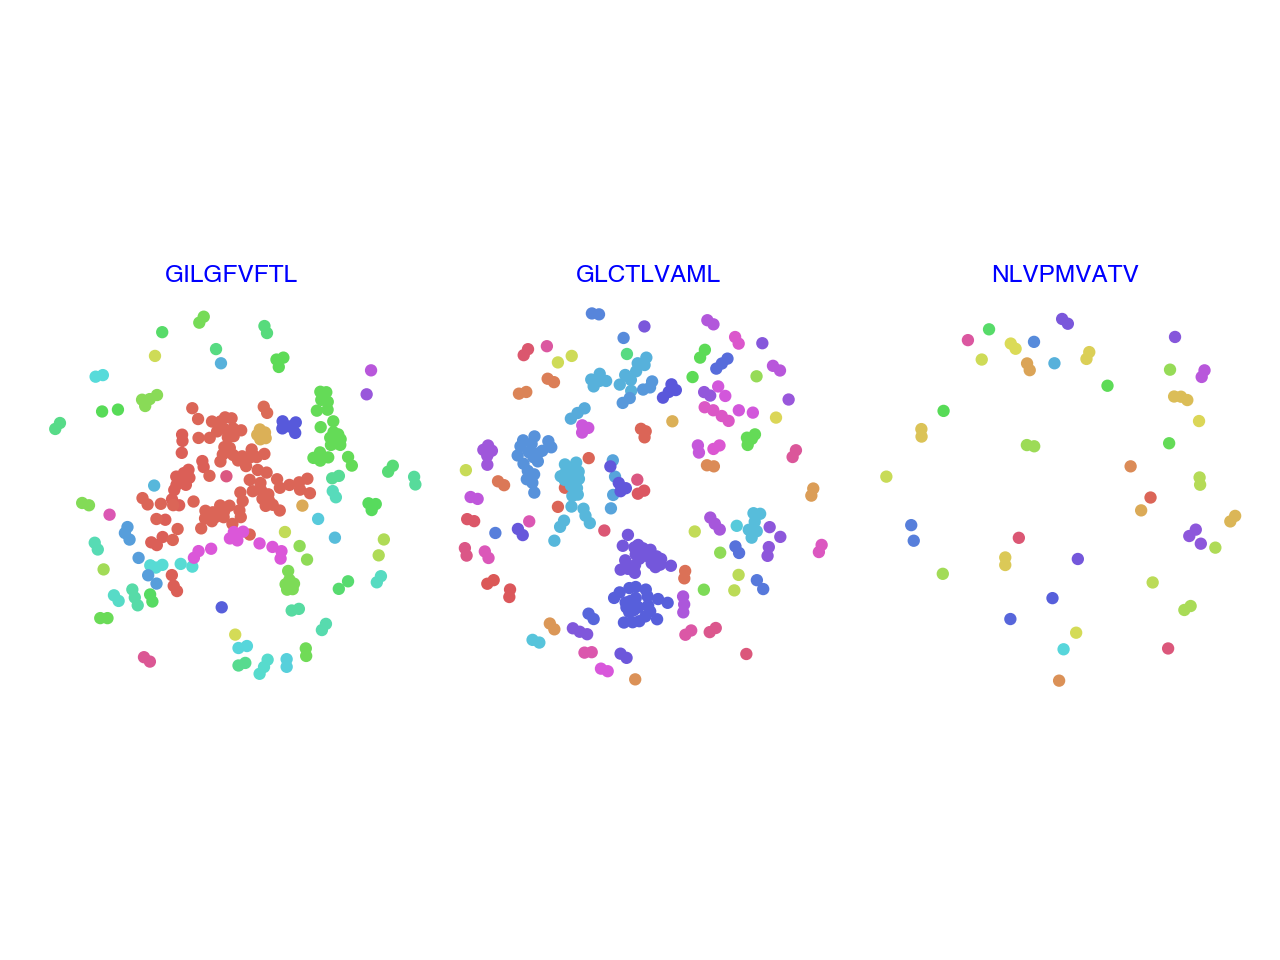

In [10]:
df_plt['cc'] = df_plt['cluster_id'].astype("str")
plt = (ggplot(df_plt, aes(x='x', y='y', color='cc')) + 
       geom_point() + 
       scale_color_discrete(guide=False) +
       xlab('') +
       ylab('') +
       facet_wrap('antigen.epitope') +
       theme_void() +
       theme(aspect_ratio = 1,
             strip_text = element_text(colour = 'blue')))
print(plt) 